### Imports / Authenticate

In [1]:
import ee 
import folium
from datetime import datetime as dt
from IPython.display import Image

In [2]:
ee.Initialize()
ee.Authenticate()

Enter verification code: 4/1AY0e-g5b9QIY9GIAGjxQ2GSFB6958XvuxvTMDYJ-nrUfOZoIlgv4GLw1C64

Successfully saved authorization token.


### Get collection

In [3]:
# map log latt :
Ituna_map = folium.Map(location=[48.8, 2.7], zoom_start=12)
Ituna_map

In [4]:
def image_coll_point(date_start, date_end, point):
    '''
    return the collection of image on "LANDSAT/LC08/C01/T1_SR"
    between start date and end date ('2019-09-21','2019-12-21')
    on the Geometry.Point
    '''
    landsat = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")

    # filter area
    landsat_AOI = landsat.filterBounds(point)

    # choose dates
    return landsat_AOI.filterDate(date_start,date_end)
    

In [5]:
point = ee.Geometry.Point([2.7, 48.8])
landsat_AOI = image_coll_point('2019-09-21','2019-12-21', point)

print('Total number:', landsat_AOI.size().getInfo())

Total number: 6


### Explore one image

In [6]:
first_image = landsat_AOI.first()

# the least cloudy image
least_cloudy = ee.Image(landsat_AOI.sort('CLOUD_COVER').first())

least_cloudy.getInfo()

# how cloudy is it?
print('Cloud Cover (%):', least_cloudy.get('CLOUD_COVER').getInfo())

# when was this image taken?
date = ee.Date(first_image.get('system:time_start'))
time = date.getInfo()['value']/1000.

print ('first :' , dt.utcfromtimestamp(time).strftime('%Y-%m-%d %H:%M:%S'))

date = ee.Date(least_cloudy.get('system:time_start'))
time = date.getInfo()['value']/1000.
print ('cloudy :' , dt.utcfromtimestamp(time).strftime('%Y-%m-%d %H:%M:%S'))


Cloud Cover (%): 6.78
first : 2019-11-02 10:35:02
cloudy : 2019-12-04 10:34:58


In [7]:
parameters = {'min': 0,
              'max': 1000,
              'dimensions': 512,
              'bands': ['B4', 'B3', 'B2'],
              'region': least_cloudy.geometry()}

In [8]:
Image(url = least_cloudy.getThumbUrl(parameters))

### Export to file GeoTiff

In [9]:
# OPTICAL_BANDS = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
# THERMAL_BANDS = ['B10', 'B11']
# BEFORE_BANDS = OPTICAL_BANDS + THERMAL_BANDS
# AFTER_BANDS = [str(s) + '_1' for s in BEFORE_BANDS]
# BANDS = BEFORE_BANDS + AFTER_BANDS


In [10]:
# def maskL8sr(image):
#   cloudShadowBitMask = ee.Number(2).pow(3).int()
#   cloudsBitMask = ee.Number(2).pow(5).int()
#   qa = image.select('pixel_qa')
#   mask1 = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
#     qa.bitwiseAnd(cloudsBitMask).eq(0))
#   mask2 = image.mask().reduce('min')
#   mask3 = image.select(OPTICAL_BANDS).gt(0).And(
#           image.select(OPTICAL_BANDS).lt(10000)).reduce('min')
#   mask = mask1.And(mask2).And(mask3)
#   return image.select(OPTICAL_BANDS).divide(10000).addBands(
#           image.select(THERMAL_BANDS).divide(10).clamp(273.15, 373.15)
#             .subtract(273.15).divide(100)).updateMask(mask)

# # Make "before" and "after" composites.
# composite1 = landsat_AOI.map(maskL8sr).median()


In [11]:
# export_image = 'projects/google/logistic_demo_image'
# composite1 = least_cloudy.select(OPTICAL_BANDS)

# image_task = ee.batch.Export.image.toDrive(
#   image = composite1, 
#   description = 'demo_image', 
#   folder = export_image, 
#   region = least_cloudy.geometry(),
#     fileFormat= 'TFRecord',
#   scale = 30,
# #   maxPixels = 1e10
# )

# image_task.start()

In [57]:
export_image = 'projects/google/logistic_demo_image'
#Load a landsat image and select three bands.
landsat = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_123032_20140515').select(['B4', 'B3', 'B2'])
# image_rgb = landsat.visualize(**{'bands': ['B5', 'B4', 'B3'], 'max': 0.5})

# Create a geometry representing an export region.
geometry = ee.Geometry.Rectangle([116.2621, 39.8412, 116.4849, 40.01236])

#Export the image, specifying scale and region.
image_task = ee.batch.Export.image.toDrive(
    image= landsat,
    folder = export_image, 
    description= 'TFRecordExample6',
    fileFormat= 'TFRecord',
    scale= 30,
    region= geometry
)
image_task.start()

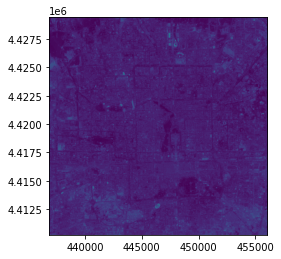

<AxesSubplot:>

In [54]:
import rasterio
from rasterio.plot import show
fp = 'imageToDriveExample6.tif'
img = rasterio.open(fp)
show(img)

In [55]:
type(img)

rasterio.io.DatasetReader

### Export TFRecord

In [12]:
image_export_options = {
  'patchDimensions': [366, 366],
  'maxFileSize': 104857600,
#   'kernelSize': [366, 366],
  'compressed': True
}

export_image = 'projects/google/logistic_demo_image'
#Load a landsat image and select three bands.
landsat = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_123032_20140515').select(['B4', 'B3', 'B2'])
# image_rgb = landsat.visualize(**{'bands': ['B5', 'B4', 'B3'], 'max': 0.5})

# Create a geometry representing an export region.
geometry = ee.Geometry.Rectangle([116.2621, 39.8412, 116.4849, 40.01236])

#Export the image, specifying scale and region.
image_task = ee.batch.Export.image.toCloudStorage(
    image= landsat,
   # folder = export_image,
    bucket = 'wagon-data-589-rezler',
    description= 'TFRecordExample',
    fileNamePrefix = 'data_forest_guards',
    fileFormat= 'TFRecord',
    scale= 30,
    region= geometry,
    formatOptions= image_export_options
)
image_task.start()
# Monitor task progress
# Code Extracted here:
# https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/TF_demo1_keras.ipynb
import time 
while tf_task.active():
  print('Polling for task (id: {}).'.format(tf_task.id))
  time.sleep(5)
	
print('Done!')

In [70]:
import tensorflow as tf
file_prefix='TFRecordExample'
image_dataset = tf.data.TFRecordDataset(str((file_prefix+'-00000.tfrecord.gz')), compression_type='GZIP')
first = next(iter(image_dataset))


<tf.Tensor: shape=(), dtype=string, numpy=b'\n\xec\x8eb\n\xa0\xda \n\x02B4\x12\x98\xda \x12\x94\xda \n\x90\xda \xb0\x83\x14>\x95T\x14>\x15\x03\x05>+\xd1\x05>6\x14\x01>o\xd1\x07>\xde\xec\x0e>\xcb\xc5\x1e><u,>|\x95+>\x82@.>S\x0e->\xd7\xe4*>\xa8{0>s\xe66>?\xc1(>\xca\xfa\x1e>7\x82\x1f>^>\x1e>\xaf\x94%>\xe3\x95D>\xd3\xf1I>L=B>&99>\x10k8>\xb2\xbc2>\x11\xd9*>Z\xdf\x17>=\x9b\x14>f\xeb\x19>\xd1\xa7\x1a>\xa1\xe1\x12>\x05(\x11>\t\x08\x14>\x10\xfd\x19>\xd6\x87\x1d>%\x81\x17>L=\x16>\x95T\x14>\x08\xbe\x10>\xda\xd5\x12>&\xcb\x1a>BW(>\x8e\x04&>\xaa\xb4">3\xec\x1f>l\x96\x1c>\xfe\x8d\x1f>G\xef >\x05;\x1b>\x93\x89\x14>\xe5\xe1\x14>\xea\xf8\x10>\x8a\x92\x15>\xb6.\x17>\xca1\x18>\x80\x99\x1d>\xc8\xc1,>\xbe\x80*>\xbb!$>\xab5\x1f>/\x0c\x1d>h\x00\x1d>\x8e\xf1\x1b>t\x8d\x1b>\xa7U\x1c>w\xa2\x1e>]\xf4\x1a>\xb7\xc2\x1d>\x99\xfd\x1d>\xea\xc1\x17>Z\x95\x14>!\xeb\x17>\xeb\x8c\x17>\x97i\x17>@\xb0\x17>\x80\xd0\x16>\xbc\x10\x13>\xde\xb5\x15>\xe3\x95\x18>\xf17\x1a>]\xbd!>\tc(>\x98E(>\x8d9&>\xc5\xac)>\x1e1)>\n\xad+>%](>1\

In [71]:
type(first)

tensorflow.python.framework.ops.EagerTensor

In [75]:
type(first.numpy())

bytes

### Add image in folium

In [115]:
ndvi = least_cloudy.normalizedDifference(['B5', 'B4'])

In [116]:
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True
  ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

In [129]:
palette = ['red', 'yellow', 'green']
ndvi_parameters = {'bands':['B11', 'B4', 'B7'],
                    'min': 0,
                   'max': 4000,
#                    'dimensions': 512,
#                   'palette': palette,
                   'region': Ituna_AOI}
Ituna_map.add_ee_layer(least_cloudy ,ndvi_parameters, 'test')
Ituna_map